In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
import gensim
from gensim.models import KeyedVectors
from IPython.display import clear_output
from collections import Counter
from tqdm import tqdm
import seaborn as sns

%matplotlib inline

In [2]:
from pymystem3 import Mystem
from string import punctuation

In [3]:
def read_queries(path):
    f = open(path)
    queries = []
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        for q in tokenizer.tokenize(line.lower()):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                tmp.append(q)
        queries.append(tmp)
    f.close()
    return queries

def read_queries_with_lemmatization(path):
    f = open(path)
    queries = []
    mystem = Mystem()
    tokenizer = WordPunctTokenizer()
    
    for line in f:
        tmp = []
        for q in tokenizer.tokenize(line.lower()):
            if not np.all(np.any(np.array(list(q)).reshape(-1, 1) == np.array(list(punctuation)).reshape(1, -1), axis=1)):
                q_ = mystem.lemmatize(q)
                tmp.append("".join(q_).split()[0])
        queries.append(tmp)
    f.close()
    return queries

In [4]:
path = 'data/requests.uniq.train'
train = read_queries(path)
train_lem = read_queries_with_lemmatization(path)
path = 'data/requests.uniq.test'
test = read_queries(path)
test_lem = read_queries_with_lemmatization(path)
train[:5], train_lem[:5], test[:5], test_lem[:5], len(train), len(test)

([['сибирские', 'сети', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карте', 'россии'],
  ['ноофен', 'для', 'каких', 'болезней'],
  ['маус', 'хаус', 'спб']],
 [['сибирский', 'сеть', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карта', 'россия'],
  ['ноофен', 'для', 'какой', 'болезнь'],
  ['маус', 'хаус', 'спб']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикая', 'вишня'],
  ['тася', 'кривун', 'танцы', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 [['сбербанк', 'в', 'кунцево', 'плаза'],
  ['торт', 'дикий', 'вишня'],
  ['тася', 'кривун', 'танец', 'на', 'тнт'],
  ['рбт', 'ру'],
  ['toplü', 'vay', 'sexx']],
 51353,
 21174)

In [5]:
were_changed = 0
all_ = 0
for i in range(len(train)):
    for j in range(len(train[i])):
        all_ += 1
        if train[i][j] != train_lem[i][j]:
            were_changed += 1
were_changed / all_

0.3257316609654124

In [6]:
count_words = Counter()

for d in [train]:
    for q in d:
        for word in q:
            count_words[word] += 1
        
freq, counts = np.unique(np.array(list(count_words.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.17574006, 0.24519813, 0.29055625, 0.32405664, 0.35185578,
        0.37601319, 0.39457541, 0.41182944, 0.42762059, 0.4410561 ]))

In [7]:
np.sum(counts), np.sum(counts[2:])

(59343, 11721)

In [51]:
count_words = Counter()

for d in [train_lem]:
    for q in d:
        for word in q:
            count_words[word] += 1
        
freq, counts = np.unique(np.array(list(count_words.values())), return_counts=True) 
p = counts * freq 
p = p / p.sum()
p = np.cumsum(p)
freq[:10], p[:10]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([0.12185658, 0.16966756, 0.20326518, 0.23018925, 0.2515358 ,
        0.27062838, 0.28792218, 0.30358516, 0.31885922, 0.32964299]))

In [52]:
np.sum(counts), np.sum(counts[2:])

(43111, 10130)

## LSTM с различными эмбеддингами

### с лемматизацией и без

In [53]:
emb = KeyedVectors.load_word2vec_format("wiki.ru.vec")

In [8]:
emb_1 = KeyedVectors.load_word2vec_format("cc.ru.300.vec")

In [9]:
emb_2 = KeyedVectors.load_word2vec_format("ft_native_300_ru_wiki_lenta_lower_case.vec")

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [11]:
def calculate_n_tokens(emb):
    n_tokens = 0
    for word in count_words.keys():
        if word in emb.vocab and count_words[word] >= 3:
            n_tokens += 1
    return n_tokens + 1

In [125]:
calculate_n_tokens(emb), calculate_n_tokens(emb_1), calculate_n_tokens(emb_2) 

(11110, 10627, 11453)

In [12]:
def transform_to_features(emb, emb_size, ind_to_word, batch_x):
    to_emb = np.zeros((len(batch_x), len(batch_x[0])+1, emb_size))
    for i in range(len(batch_x)):
        to_emb[i][0] = np.ones(emb_size)
        for j in range(len(batch_x[i])):
            if batch_x[i][j] != pad_id:
                to_emb[i][j+1] = emb[ind_to_word[batch_x[i][j]]]
    return to_emb

In [13]:
class Net(nn.Module):
    def __init__(self, emb, ind_to_word, emb_size=300, lstm_units=256):
        super(self.__class__, self).__init__()
        n_tokens = calculate_n_tokens(emb)
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
        self.logits = nn.Linear(lstm_units, n_tokens) 
        self.emb = emb
        self.emb_size = emb_size
        self.ind_to_word = ind_to_word
        
    def forward(self, batch_x):
        input_emb = transform_to_features(self.emb, self.emb_size, self.ind_to_word, batch_x)
        input_emb = torch.tensor(input_emb, dtype=torch.float32)
        lstm_out = self.lstm(input_emb)
        logits = self.logits(lstm_out[0])
        
        return logits        

In [14]:
pad = '#PAD#'
pad_id = 0

def construct_vocab(emb, count_words):
    word_to_ind = dict()
    word_to_ind['#PAD#'] = 0
    ind_to_word = ['#PAD#', ]
    
    count = 1
    for word in count_words.keys():
        if count_words[word] >= 3 and word in emb.vocab:
            ind_to_word.append(word)
            word_to_ind[word] = count
            count += 1
    return ind_to_word, word_to_ind

def as_matrix(sequences, word_to_ind, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype=int)
    for i, seq in enumerate(sequences):
        for j, word in enumerate(seq[:max_len]):
            if word in word_to_ind.keys():
                matrix[i][j] = word_to_ind[word]
            else:
                matrix[i][j] = pad_id
        for j in range(max_len, len(seq)):
            matrix[i][j] = pad_id
    
    return matrix

In [20]:
ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
train[:5], as_matrix(train[:5], word_to_ind)

([['сибирские', 'сети', 'личный', 'кабинет', 'бердск'],
  ['1', 'сантим', 'алжир', '1964'],
  ['река', 'колыма', 'на', 'карте', 'россии'],
  ['ноофен', 'для', 'каких', 'болезней'],
  ['маус', 'хаус', 'спб']],
 array([[ 0,  1,  2,  3,  0],
        [ 4,  0,  0,  5,  0],
        [ 6,  0,  7,  8,  9],
        [ 0, 10, 11, 12,  0],
        [13, 14, 15,  0,  0]]))

In [21]:
ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
network = Net(emb_1, ind_to_word)

In [22]:
dummy_batch_x = as_matrix(train[:5], word_to_ind)

dummy_logits = network.forward(dummy_batch_x)

print('shape:', dummy_logits.shape)

shape: torch.Size([5, 6, 10628])


In [23]:
def compute_loss(network, batch_x):
    """
    use scalar crossentropy loss (neg llh) loss 
    """
    batch_x = np.array(batch_x)
    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    
    logits_for_next = network.forward(batch_x_inp)
    logits_for_next = logits_for_next[:, 1:]
    
    answers = torch.argmax(logits_for_next, dim=-1).numpy()
    logits_for_next = logits_for_next.contiguous()
    logits_for_next = logits_for_next.view(-1, logits_for_next.shape[-1])
    
    accr = np.array([answers == batch_x_next]) * np.array([answers != pad_id])
    accr = accr.mean()
    batch_x_next = torch.tensor(batch_x_next, dtype=torch.int64)
    batch_x_next = batch_x_next.view(-1)
    
    loss = F.cross_entropy(logits_for_next, batch_x_next, ignore_index=pad_id, reduction='mean')
    
    
    return loss, accr

In [24]:
dummy_loss, dummy_accr = compute_loss(network, dummy_batch_x)

assert dummy_loss.shape == torch.Size([]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

In [25]:
from torch.optim import Adam

opt = Adam(network.parameters())

In [26]:
from random import choice

def generate_batch(train, batch_size, word_to_ind, max_len=None):
    random_x = np.random.randint(0, len(train), size=batch_size)
    batch_x = []
    for x in random_x:
        batch_x.append(train[x])
    return as_matrix(batch_x, word_to_ind, max_len)

In [27]:
batch_size = 64 
n_epochs = 100  
n_batches_per_epoch = 400  
n_validation_batches = 160

In [28]:
len(train) / batch_size, len(test) / batch_size

(802.390625, 330.84375)

### emb и без лемматизации

In [35]:
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb, count_words)
network = Net(emb, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr = [], [], [], []

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t, accr_t = compute_loss(network, generate_batch(train, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        
    train_loss_ /= n_batches_per_epoch
    train_accr_ /= n_batches_per_epoch
    
    val_loss_=0
    val_accr_=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t = compute_loss(network, generate_batch(test, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
    val_loss_ /= n_validation_batches
    val_accr_ /= n_validation_batches
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))

print("Finished!")

  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 0, train loss: 7.622671223878861, val loss: 7.1394746661186215

Epoch: 0, train accr: 0.01339046165771652, val accr: 0.018097800048641612


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 1, train loss: 6.71602601647377, val loss: 6.575458806753159

Epoch: 1, train accr: 0.026087059246560535, val accr: 0.025448395451815924


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 2, train loss: 6.160353838205338, val loss: 6.264864519238472

Epoch: 2, train accr: 0.03143006894256096, val accr: 0.02903436289460306


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 3, train loss: 5.731523013114929, val loss: 6.107632464170456

Epoch: 3, train accr: 0.03726837527910878, val accr: 0.03154029908142869


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 4, train loss: 5.418812232017517, val loss: 6.057292622327805

Epoch: 4, train accr: 0.04167745368437054, val accr: 0.033277360663551046


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.114300377368927, val loss: 5.950650975108147

Epoch: 5, train accr: 0.04387270713642712, val accr: 0.0360907957266926


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 6, train loss: 4.897996553182602, val loss: 5.935343831777573

Epoch: 6, train accr: 0.04868802166212914, val accr: 0.03443580243595918


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.682642257809639, val loss: 5.898927417397499

Epoch: 7, train accr: 0.05201731820089961, val accr: 0.03742238480804301


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.481962509155274, val loss: 5.922384345531464

Epoch: 8, train accr: 0.05687295924233221, val accr: 0.03637323670610014


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.2960645943880085, val loss: 5.947059541940689

Epoch: 9, train accr: 0.05878392365857763, val accr: 0.0351608558363137


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.114418806433678, val loss: 5.938294425606728

Epoch: 10, train accr: 0.06544354355130344, val accr: 0.03687505863359641


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.9051584994792936, val loss: 5.996386176347732

Epoch: 11, train accr: 0.0710163598793967, val accr: 0.037152650490249024


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.780373965501785, val loss: 5.971921709179878

Epoch: 12, train accr: 0.07353332700154942, val accr: 0.03703464060149644


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.646620386838913, val loss: 6.007755082845688

Epoch: 13, train accr: 0.07838597734581547, val accr: 0.036371846066940085


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.530631050467491, val loss: 6.024186983704567

Epoch: 14, train accr: 0.08195720765325726, val accr: 0.03820906911922527


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.4070708465576174, val loss: 6.0635532438755035

Epoch: 15, train accr: 0.08526162803328177, val accr: 0.03573004715734735


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.3217184180021286, val loss: 6.086744508147239

Epoch: 16, train accr: 0.087338901427904, val accr: 0.03626057822515387


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.1840603721141814, val loss: 6.183137547969818

Epoch: 17, train accr: 0.09215102069543843, val accr: 0.03503935518796831


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.1010964900255202, val loss: 6.121600332856178

Epoch: 18, train accr: 0.09503738744379858, val accr: 0.03606126724890567


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.017573115229607, val loss: 6.150854456424713

Epoch: 19, train accr: 0.1000758219572616, val accr: 0.037481509818435045


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 20, train loss: 2.9091727930307387, val loss: 6.201415035128593

Epoch: 20, train accr: 0.1013911625769927, val accr: 0.03894795439755198


 26%|██▌       | 103/400 [00:48<02:20,  2.12it/s]

KeyboardInterrupt: 

In [36]:
torch.save(network.state_dict(), 'emb_no_lemmatization.pwf')

In [34]:
def compute_accr(network, batch_x):
    """
    use scalar crossentropy loss (neg llh) loss 
    """
    batch_x = np.array(batch_x)
    batch_x_inp = batch_x[:, :-1]
    batch_x_next = batch_x[:, 1:]
    
    logits_for_next = network.forward(batch_x_inp)
    logits_for_next = logits_for_next[:, 1:]
    
    answers = torch.argmax(logits_for_next, dim=-1).numpy()
    accr = np.array([answers == batch_x_next]) * np.array([answers != pad_id])
    accr = accr[0]
    accr = accr.sum(axis=0)
    to_divide = np.array([batch_x_next != pad_id])[0].sum(axis=0)
    
    return accr, to_divide

In [98]:
accr, to_divide = compute_accr(network, generate_batch(test, batch_size, word_to_ind))
accr, to_divide

(array([ 5,  5, 10,  3,  3,  2,  0,  0,  0]),
 array([34, 32, 30,  9, 12,  6,  2,  1,  0]))

In [32]:
def get_batch(data, left, right, batch_size, word_to_ind, max_len=None):
    slice_x = np.arange(left, right, 1)
    batch_x = []
    for x in slice_x:
        batch_x.append(data[x])
    return as_matrix(batch_x, word_to_ind, max_len)

def try_lengthes(data):
    accr = np.zeros(np.max(list(map(len, data))))
    to_div = np.zeros(np.max(list(map(len, data))))
    
    for _ in tqdm_notebook(range(0, len(data)-batch_size, batch_size)):
        accr_t, div_t = compute_accr(network, get_batch(data, _, _+batch_size, batch_size, word_to_ind))
        accr[:len(accr_t)] += accr_t
        to_div[:len(div_t)] += div_t
    eps = 1
    return accr / (to_div + eps), accr.sum() / to_div.sum()

In [104]:
from tqdm import tqdm_notebook

on_train, all_accr = try_lengthes(train)
on_train

array([0.238299  , 0.39762369, 0.55320703, 0.61953927, 0.6672619 ,
       0.66792206, 0.68522664, 0.70788108, 0.70760234, 0.67776097,
       0.62015504, 0.63247863, 0.67142857, 0.66292135, 0.55737705,
       0.48214286, 0.53191489, 0.59375   , 0.42857143, 0.65384615,
       0.5625    , 0.5       , 0.4       , 0.54545455, 0.63636364,
       0.4       , 0.54545455, 0.5       , 0.75      , 0.2       ,
       0.57142857, 0.33333333, 0.5       , 0.33333333, 0.6       ,
       0.2       , 0.25      , 0.        , 0.5       , 0.4       ,
       0.6       , 0.75      , 0.5       , 0.5       , 0.66666667,
       0.5       , 0.66666667, 0.5       , 0.        , 0.66666667,
       0.33333333, 0.5       , 0.66666667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5       , 0.5       ,
       0.        , 0.5       , 0.5       , 0.5       , 0.        ,
       0.        , 0.        , 0.        ])

In [105]:
on_train[:10], all_accr

(array([0.238299  , 0.39762369, 0.55320703, 0.61953927, 0.6672619 ,
        0.66792206, 0.68522664, 0.70788108, 0.70760234, 0.67776097]),
 0.4645881199890744)

In [102]:
on_test, all_accr = try_lengthes(test)
on_test

array([0.14579439, 0.15652655, 0.18843735, 0.20594262, 0.20559548,
       0.21215933, 0.20164609, 0.19335706, 0.15778689, 0.104     ,
       0.12878788, 0.06024096, 0.02040816, 0.05555556, 0.12      ,
       0.05882353, 0.06666667, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.5       , 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [103]:
on_test[:10], all_accr

(array([0.14579439, 0.15652655, 0.18843735, 0.20594262, 0.20559548,
        0.21215933, 0.20164609, 0.19335706, 0.15778689, 0.104     ]),
 0.1729730865390676)

In [106]:
f = open('emb_no_lemmatization.txt', 'w')
for x in [train_loss, val_loss, train_accr, val_accr, on_train, on_test]:
    print(len(x), file=f)
    for y in x:
        print(y, file=f)
f.close()

In [109]:
def approximate_pad(data):
    to_pad = 0
    all_ = 0
    for x in data:
        for word in x:
            all_ += 1
            if word not in word_to_ind.keys():
                to_pad += 1
    return to_pad / all_

pad_train = approximate_pad(train)
pad_test = approximate_pad(test)
pad_train, pad_test

(0.3014991205041853, 0.34950137458897096)

In [111]:
on_train[:10] * (1 - pad_train), on_test[:10] * (1 - pad_test)

(array([0.16645206, 0.2777405 , 0.3864156 , 0.43274872, 0.46608303,
        0.46654414, 0.47863141, 0.49445555, 0.49426086, 0.47341663]),
 array([0.09483905, 0.1018203 , 0.12257824, 0.13396539, 0.13373958,
        0.13800935, 0.1311705 , 0.1257785 , 0.10264015, 0.06765186]))

## emb_1 без лемматизации

In [29]:
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
network = Net(emb_1, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr = [], [], [], []

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t, accr_t = compute_loss(network, generate_batch(train, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        
    train_loss_ /= n_batches_per_epoch
    train_accr_ /= n_batches_per_epoch
    
    val_loss_=0
    val_accr_=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t = compute_loss(network, generate_batch(test, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
    val_loss_ /= n_validation_batches
    val_accr_ /= n_validation_batches
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))

print("Finished!")

  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 0, train loss: 7.5759016799926755, val loss: 7.219655388593674

Epoch: 0, train accr: 0.013899987344670628, val accr: 0.013398390802544064


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 1, train loss: 6.9464906108379365, val loss: 6.840568879246712

Epoch: 1, train accr: 0.020275055528230577, val accr: 0.01901966012991419


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 2, train loss: 6.461477018594742, val loss: 6.580781051516533

Epoch: 2, train accr: 0.026139218130902264, val accr: 0.02331693554882954


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 3, train loss: 6.154805185794831, val loss: 6.344854253530502

Epoch: 3, train accr: 0.03076168978521259, val accr: 0.02804260347420201


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 4, train loss: 5.849890427589417, val loss: 6.2929868459701535

Epoch: 4, train accr: 0.03436999168357215, val accr: 0.02806944673349739


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.632944195270539, val loss: 6.223384761810303

Epoch: 5, train accr: 0.03683538345230236, val accr: 0.029449337809922888


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 6, train loss: 5.4241731023788455, val loss: 6.130182817578316

Epoch: 6, train accr: 0.03998388979065543, val accr: 0.03190792936597399


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 7, train loss: 5.20414885520935, val loss: 6.167538213729858

Epoch: 7, train accr: 0.04305193989344129, val accr: 0.03162143020168602


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 8, train loss: 5.050506669282913, val loss: 6.108992406725884

Epoch: 8, train accr: 0.0454496070042436, val accr: 0.033858871352836634


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.904259663820267, val loss: 6.0748706489801405

Epoch: 9, train accr: 0.048890592901041655, val accr: 0.03410517413292602


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.762132031917572, val loss: 6.03670634329319

Epoch: 10, train accr: 0.05175005407162222, val accr: 0.03583203480941176


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.627712616324425, val loss: 6.072171753644943

Epoch: 11, train accr: 0.05454356867189665, val accr: 0.033937405094007264


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.485761934518814, val loss: 6.056092745065689

Epoch: 12, train accr: 0.0564093350906626, val accr: 0.03541140198930744


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 13, train loss: 4.346553675532341, val loss: 6.0925722301006315

Epoch: 13, train accr: 0.06103256283932951, val accr: 0.0350397317247166


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 14, train loss: 4.242342963218689, val loss: 6.083721953630447

Epoch: 14, train accr: 0.06437728316224571, val accr: 0.035092991486376866


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 15, train loss: 4.161626307368278, val loss: 6.131674706935883

Epoch: 15, train accr: 0.06504048835850629, val accr: 0.03481288847452698


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 16, train loss: 4.041648636460304, val loss: 6.104231125116348

Epoch: 16, train accr: 0.06901570769071283, val accr: 0.03612273723455365


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.942579899430275, val loss: 6.127609848976135

Epoch: 17, train accr: 0.0718828486617008, val accr: 0.036987165939534106


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.8696552622318268, val loss: 6.135520187020302

Epoch: 18, train accr: 0.07500899749763398, val accr: 0.03646068855844048


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.76669729411602, val loss: 6.160533353686333

Epoch: 19, train accr: 0.0772012115397362, val accr: 0.03745658628518299


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.7003940671682356, val loss: 6.185795658826828

Epoch: 20, train accr: 0.08031729187611827, val accr: 0.03579752500231591


  2%|▎         | 10/400 [00:04<03:07,  2.08it/s]


KeyboardInterrupt: 

In [30]:
torch.save(network.state_dict(), 'emb_1_no_lemmatization.pwf')

In [35]:
from tqdm import tqdm_notebook

on_train, all_accr = try_lengthes(train)
on_train

array([0.18366113, 0.26847086, 0.38524107, 0.44687777, 0.51205206,
       0.52827068, 0.57356672, 0.57613345, 0.56994819, 0.58753316,
       0.54060325, 0.52434457, 0.60759494, 0.52      , 0.37142857,
       0.48214286, 0.52083333, 0.42424242, 0.32258065, 0.55555556,
       0.27777778, 0.4       , 0.4       , 0.41666667, 0.36363636,
       0.4       , 0.54545455, 0.2       , 0.5       , 0.33333333,
       0.42857143, 0.16666667, 0.75      , 0.        , 0.6       ,
       0.6       , 0.25      , 0.5       , 0.75      , 0.2       ,
       0.6       , 0.5       , 0.        , 0.5       , 0.66666667,
       0.5       , 0.        , 0.66666667, 0.33333333, 0.33333333,
       0.33333333, 0.5       , 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5       , 0.5       ,
       0.5       , 0.        , 0.5       , 0.5       , 0.        ,
       0.5       , 0.        , 0.        ])

In [36]:
on_train[:10], all_accr

(array([0.18366113, 0.26847086, 0.38524107, 0.44687777, 0.51205206,
        0.52827068, 0.57356672, 0.57613345, 0.56994819, 0.58753316]),
 0.3448922423530475)

In [37]:
on_test, all_accr = try_lengthes(test)
on_test

array([0.14574532, 0.15138371, 0.16934596, 0.18106804, 0.18764515,
       0.19239544, 0.20048751, 0.19385593, 0.16423358, 0.10921502,
       0.13157895, 0.04301075, 0.03703704, 0.04878049, 0.14814815,
       0.        , 0.        , 0.        , 0.08333333, 0.        ,
       0.        , 0.        , 0.        , 0.11111111, 0.11111111,
       0.        , 0.        , 0.2       , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.5       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [38]:
on_test[:10], all_accr

(array([0.14574532, 0.15138371, 0.16934596, 0.18106804, 0.18764515,
        0.19239544, 0.20048751, 0.19385593, 0.16423358, 0.10921502]),
 0.16344237308007972)

In [39]:
f = open('emb_1_no_lemmatization.txt', 'w')
for x in [train_loss, val_loss, train_accr, val_accr, on_train, on_test]:
    print(len(x), file=f)
    for y in x:
        print(y, file=f)
f.close()

In [40]:
def approximate_pad(data):
    to_pad = 0
    all_ = 0
    for x in data:
        for word in x:
            all_ += 1
            if word not in word_to_ind.keys():
                to_pad += 1
    return to_pad / all_

pad_train = approximate_pad(train)
pad_test = approximate_pad(test)
pad_train, pad_test

(0.26651374930391664, 0.31058163980378417)

In [41]:
on_train[:10] * (1 - pad_train), on_test[:10] * (1 - pad_test)

(array([0.13471291, 0.19691969, 0.28256902, 0.3277787 , 0.37558314,
        0.38747928, 0.4207033 , 0.42258596, 0.41804916, 0.43094749]),
 array([0.1004795 , 0.10436671, 0.11675021, 0.12483163, 0.12936601,
        0.13264095, 0.13821977, 0.13364784, 0.11322564, 0.07529484]))

## emb_2 без лемматизации

In [42]:
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = Net(emb_2, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr = [], [], [], []

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t, accr_t = compute_loss(network, generate_batch(train, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        
    train_loss_ /= n_batches_per_epoch
    train_accr_ /= n_batches_per_epoch
    
    val_loss_=0
    val_accr_=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t = compute_loss(network, generate_batch(test, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
    val_loss_ /= n_validation_batches
    val_accr_ /= n_validation_batches
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))

print("Finished!")

  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 0, train loss: 7.573364926576614, val loss: 7.060833516716957

Epoch: 0, train accr: 0.015309715183411626, val accr: 0.019700989993222687


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 1, train loss: 6.675879417657852, val loss: 6.515012386441231

Epoch: 1, train accr: 0.028391498491954274, val accr: 0.027877580022357136


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 2, train loss: 6.135915530920029, val loss: 6.275737836956978

Epoch: 2, train accr: 0.035263723795089574, val accr: 0.03019338410476281


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 3, train loss: 5.728771487474441, val loss: 6.116731458902359

Epoch: 3, train accr: 0.0391816319983854, val accr: 0.032740356256640624


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 4, train loss: 5.388618776798248, val loss: 6.009329384565353

Epoch: 4, train accr: 0.043336704400099, val accr: 0.03483799357520211


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.129002797603607, val loss: 5.9832462012767795

Epoch: 5, train accr: 0.04883789284414977, val accr: 0.03584421842996308


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 6, train loss: 4.867548226118088, val loss: 5.92528510093689

Epoch: 6, train accr: 0.05273124667736496, val accr: 0.0376113478176542


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.665871888995171, val loss: 5.970438671112061

Epoch: 7, train accr: 0.05609687509489501, val accr: 0.03728473658109041


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.494494246244431, val loss: 5.891310638189315

Epoch: 8, train accr: 0.060434923017782284, val accr: 0.03804824545412209


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.296379308700562, val loss: 5.912616020441055

Epoch: 9, train accr: 0.0657562665066211, val accr: 0.0378777059860961


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.141620235443115, val loss: 5.93852961063385

Epoch: 10, train accr: 0.07012649025121759, val accr: 0.03895571601377839


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.9927767688035964, val loss: 5.890201580524445

Epoch: 11, train accr: 0.07353394003705355, val accr: 0.04113404237096812


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.8391689920425414, val loss: 5.992702290415764

Epoch: 12, train accr: 0.07797074972850188, val accr: 0.037333861668468735


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.6995256221294404, val loss: 5.8840031832456585

Epoch: 13, train accr: 0.08308696737704364, val accr: 0.0400427026480981


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.5882434648275376, val loss: 6.001148986816406

Epoch: 14, train accr: 0.08801899459087519, val accr: 0.03804224295186799


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.483913013935089, val loss: 6.006356021761894

Epoch: 15, train accr: 0.08691905562597388, val accr: 0.0394796640458097


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.3794088900089263, val loss: 6.100860375165939

Epoch: 16, train accr: 0.09266443181115191, val accr: 0.037909728246899324


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.283303691148758, val loss: 6.079112640023231

Epoch: 17, train accr: 0.09519792873441117, val accr: 0.03957686483043353


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.180810897946358, val loss: 6.070009157061577

Epoch: 18, train accr: 0.09799246604742773, val accr: 0.038756545591753996


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.1009928131103517, val loss: 6.149681797623634

Epoch: 19, train accr: 0.10415023247498337, val accr: 0.03962736724644137


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.0193233066797256, val loss: 6.159938371181488

Epoch: 20, train accr: 0.10568152749422581, val accr: 0.03977213754889628


  2%|▏         | 8/400 [00:03<02:56,  2.23it/s]


KeyboardInterrupt: 

In [43]:
torch.save(network.state_dict(), 'emb_2_no_lemmatization.pwf')

In [44]:
from tqdm import tqdm_notebook

on_train, all_accr = try_lengthes(train)
on_train

array([0.23771297, 0.379849  , 0.52387494, 0.57250924, 0.62541927,
       0.62772748, 0.64846502, 0.64798301, 0.63997061, 0.60369881,
       0.58333333, 0.57462687, 0.5408805 , 0.54      , 0.34782609,
       0.47368421, 0.5       , 0.5       , 0.4516129 , 0.59259259,
       0.44444444, 0.65      , 0.46666667, 0.5       , 0.54545455,
       0.4       , 0.45454545, 0.1       , 0.75      , 0.16666667,
       0.57142857, 0.16666667, 0.25      , 0.        , 0.4       ,
       0.2       , 0.        , 0.        , 0.25      , 0.2       ,
       0.4       , 0.25      , 0.5       , 0.5       , 0.33333333,
       0.5       , 0.66666667, 0.33333333, 0.66666667, 0.        ,
       0.33333333, 0.5       , 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.5       , 0.        ,
       0.        , 0.5       , 0.5       , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [45]:
on_train[:10], all_accr

(array([0.23771297, 0.379849  , 0.52387494, 0.57250924, 0.62541927,
        0.62772748, 0.64846502, 0.64798301, 0.63997061, 0.60369881]),
 0.4428555559669715)

In [46]:
on_test, all_accr = try_lengthes(test)
on_test

array([0.14961039, 0.1584489 , 0.18388294, 0.19987643, 0.20879374,
       0.20773854, 0.20739842, 0.19017764, 0.14774775, 0.11904762,
       0.10596026, 0.06451613, 0.03703704, 0.09756098, 0.03703704,
       0.        , 0.        , 0.        , 0.16666667, 0.        ,
       0.        , 0.        , 0.        , 0.22222222, 0.11111111,
       0.        , 0.        , 0.2       , 0.        , 0.        ,
       0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.5       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [47]:
on_test[:10], all_accr

(array([0.14961039, 0.1584489 , 0.18388294, 0.19987643, 0.20879374,
        0.20773854, 0.20739842, 0.19017764, 0.14774775, 0.11904762]),
 0.17352674173797153)

In [48]:
f = open('emb_2_no_lemmatization.txt', 'w')
for x in [train_loss, val_loss, train_accr, val_accr, on_train, on_test]:
    print(len(x), file=f)
    for y in x:
        print(y, file=f)
f.close()

In [49]:
pad_train = approximate_pad(train)
pad_test = approximate_pad(test)
pad_train, pad_test

(0.2518495929569622, 0.30184895692954555)

In [50]:
on_train[:10] * (1 - pad_train), on_test[:10] * (1 - pad_test)

(array([0.17784506, 0.28418418, 0.39193725, 0.42832302, 0.46790768,
        0.46963457, 0.48514937, 0.48478876, 0.47879427, 0.45165751]),
 array([0.10445065, 0.11062126, 0.12837807, 0.13954394, 0.14576957,
        0.14503288, 0.14479543, 0.13277272, 0.10315024, 0.08311322]))

## emb с лемматизацией

In [54]:
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb, count_words)
network = Net(emb, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr = [], [], [], []
n_epochs = 21

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t, accr_t = compute_loss(network, generate_batch(train_lem, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        
    train_loss_ /= n_batches_per_epoch
    train_accr_ /= n_batches_per_epoch
    
    val_loss_=0
    val_accr_=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t = compute_loss(network, generate_batch(test_lem, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
    val_loss_ /= n_validation_batches
    val_accr_ /= n_validation_batches
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))

print("Finished!")

  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 0, train loss: 7.486110054254532, val loss: 7.08984504044056

Epoch: 0, train accr: 0.012731738317982964, val accr: 0.017838529831456007


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 1, train loss: 6.665219476222992, val loss: 6.610638508200646

Epoch: 1, train accr: 0.026112738741846057, val accr: 0.025722919404924178


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 2, train loss: 6.151095832586289, val loss: 6.363744741678238

Epoch: 2, train accr: 0.03332001954554652, val accr: 0.028467639254338845


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 3, train loss: 5.84568550825119, val loss: 6.1738261282444

Epoch: 3, train accr: 0.03713337406436386, val accr: 0.03269592160302785


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 4, train loss: 5.5337614095211025, val loss: 6.103510043025016

Epoch: 4, train accr: 0.04066205860068485, val accr: 0.03526289613755427


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.297826492786408, val loss: 6.090294191241265

Epoch: 5, train accr: 0.043581325020478755, val accr: 0.03424411024906862


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 6, train loss: 5.075005347728729, val loss: 6.084498152136803

Epoch: 6, train accr: 0.04869242925523611, val accr: 0.034695078516117396


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 7, train loss: 4.886787386536598, val loss: 6.0491172015666965

Epoch: 7, train accr: 0.051797938058839296, val accr: 0.03653287301839146


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 8, train loss: 4.667478277683258, val loss: 6.031676480174065

Epoch: 8, train accr: 0.05763868922809901, val accr: 0.03608032737635258


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 9, train loss: 4.5216268849372865, val loss: 6.050783684849739

Epoch: 9, train accr: 0.058417036782211225, val accr: 0.03783189993380762


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.345464873313904, val loss: 5.989963313937187

Epoch: 10, train accr: 0.06417662133957319, val accr: 0.03923670441992478


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.200509400367737, val loss: 6.0696717470884325

Epoch: 11, train accr: 0.0681146134493598, val accr: 0.037200722678152075


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.054871160387993, val loss: 6.125854268670082

Epoch: 12, train accr: 0.07367968420608972, val accr: 0.03710079009730308


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.9050816106796264, val loss: 6.136352494359016

Epoch: 13, train accr: 0.07839529261564902, val accr: 0.03868767737567847


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.7736862778663633, val loss: 6.1235028326511385

Epoch: 14, train accr: 0.0812454942998777, val accr: 0.03962292059690262


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.655588322877884, val loss: 6.182978191971779

Epoch: 15, train accr: 0.08707820684727847, val accr: 0.03816465238893853


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.5611239671707153, val loss: 6.2148422539234165

Epoch: 16, train accr: 0.09034920879972119, val accr: 0.038559980802915075


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.46996016561985, val loss: 6.193069821596145

Epoch: 17, train accr: 0.0910976295199937, val accr: 0.038936838929189026


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.351799161434174, val loss: 6.2771266251802444

Epoch: 18, train accr: 0.09594836502592058, val accr: 0.036910930255389066


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.248538827300072, val loss: 6.341492000222206

Epoch: 19, train accr: 0.09930432074151029, val accr: 0.0370798972089504


100%|██████████| 400/400 [02:37<00:00,  2.50it/s]



Epoch: 20, train loss: 3.1713270783424377, val loss: 6.35072825551033

Epoch: 20, train accr: 0.10089383636919219, val accr: 0.038716173002019356
Finished!


In [55]:
torch.save(network.state_dict(), 'emb_lemmatization.pwf')

In [56]:
from tqdm import tqdm_notebook

on_train, all_accr = try_lengthes(train_lem)
on_train

array([0.22078905, 0.36494518, 0.50583546, 0.55356729, 0.59245081,
       0.60209576, 0.61923454, 0.61342786, 0.59322034, 0.59007833,
       0.56823266, 0.56666667, 0.54166667, 0.45283019, 0.43421053,
       0.40625   , 0.48148148, 0.43589744, 0.34375   , 0.42857143,
       0.28571429, 0.36842105, 0.1875    , 0.28571429, 0.42857143,
       0.15384615, 0.5       , 0.45454545, 0.33333333, 0.14285714,
       0.5       , 0.28571429, 0.2       , 0.25      , 0.2       ,
       0.4       , 0.25      , 0.4       , 0.4       , 0.4       ,
       0.2       , 0.25      , 0.        , 0.5       , 0.        ,
       0.        , 0.33333333, 0.5       , 0.        , 0.33333333,
       0.66666667, 0.33333333, 0.        , 0.5       , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.5       ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [57]:
on_train[:10], all_accr

(array([0.22078905, 0.36494518, 0.50583546, 0.55356729, 0.59245081,
        0.60209576, 0.61923454, 0.61342786, 0.59322034, 0.59007833]),
 0.42181305165677907)

In [58]:
on_test, all_accr = try_lengthes(test_lem)
on_test

array([0.13924226, 0.14592378, 0.18004685, 0.18963977, 0.18929856,
       0.19669118, 0.19010727, 0.17959184, 0.14387211, 0.11551155,
       0.1097561 , 0.03092784, 0.04761905, 0.075     , 0.0625    ,
       0.125     , 0.0952381 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09090909, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.33333333, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [59]:
on_test[:10], all_accr

(array([0.13924226, 0.14592378, 0.18004685, 0.18963977, 0.18929856,
        0.19669118, 0.19010727, 0.17959184, 0.14387211, 0.11551155]),
 0.1624574007552731)

In [60]:
f = open('emb_lemmatization.txt', 'w')
for x in [train_loss, val_loss, train_accr, val_accr, on_train, on_test]:
    print(len(x), file=f)
    for y in x:
        print(y, file=f)
f.close()

In [61]:
pad_train = approximate_pad(train_lem)
pad_test = approximate_pad(test_lem)
pad_train, pad_test

(0.22783803134363978, 0.26150611826855696)

In [62]:
on_train[:10] * (1 - pad_train), on_test[:10] * (1 - pad_test)

(array([0.17048491, 0.28179679, 0.3905869 , 0.42744361, 0.45746799,
        0.46491545, 0.47814936, 0.47366566, 0.45806218, 0.45563604]),
 array([0.10282955, 0.10776382, 0.1329635 , 0.14004781, 0.13979583,
        0.14525523, 0.14039306, 0.13262747, 0.10624868, 0.08530457]))

## emb_1 с лемматизацией

In [63]:
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
network = Net(emb_1, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr = [], [], [], []
n_epochs = 21

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t, accr_t = compute_loss(network, generate_batch(train_lem, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        
    train_loss_ /= n_batches_per_epoch
    train_accr_ /= n_batches_per_epoch
    
    val_loss_=0
    val_accr_=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t = compute_loss(network, generate_batch(test_lem, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
    val_loss_ /= n_validation_batches
    val_accr_ /= n_validation_batches
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))

print("Finished!")

  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 0, train loss: 7.417836039066315, val loss: 7.147259169816971

Epoch: 0, train accr: 0.013643797201587017, val accr: 0.013935313778640369


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 1, train loss: 6.867663125991822, val loss: 6.797101753950119

Epoch: 1, train accr: 0.02058391553209031, val accr: 0.020139727133946437


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 2, train loss: 6.448502186536789, val loss: 6.587281200289726

Epoch: 2, train accr: 0.0279959112310494, val accr: 0.025193199314223664


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 3, train loss: 6.149655247926712, val loss: 6.4058871299028395

Epoch: 3, train accr: 0.03270223555111234, val accr: 0.029314938755425658


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 4, train loss: 5.9194610095024105, val loss: 6.354270201921463

Epoch: 4, train accr: 0.03484257077096084, val accr: 0.029604901343148256


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 5, train loss: 5.683768717050552, val loss: 6.264997914433479

Epoch: 5, train accr: 0.03864821843262584, val accr: 0.030657829901346495


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 6, train loss: 5.527406538724899, val loss: 6.224744826555252

Epoch: 6, train accr: 0.04092606499675761, val accr: 0.03084572570163841


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 7, train loss: 5.35010744214058, val loss: 6.178776034712792

Epoch: 7, train accr: 0.043807113041585154, val accr: 0.033446624781106056


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 8, train loss: 5.200026341676712, val loss: 6.206966143846512

Epoch: 8, train accr: 0.046414750263856386, val accr: 0.03480954695225764


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 9, train loss: 5.056372362375259, val loss: 6.177261072397232

Epoch: 9, train accr: 0.04800798586676315, val accr: 0.03298660820561594


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 10, train loss: 4.941873215436935, val loss: 6.167085608839988

Epoch: 10, train accr: 0.051941436564366644, val accr: 0.03666554227423409


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 11, train loss: 4.823887666463852, val loss: 6.185629460215568

Epoch: 11, train accr: 0.054196267808639106, val accr: 0.035592274841250944


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 12, train loss: 4.687413430809975, val loss: 6.179124504327774

Epoch: 12, train accr: 0.057216871394475864, val accr: 0.0355130600173831


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 13, train loss: 4.5701810491085055, val loss: 6.164733657240868

Epoch: 13, train accr: 0.060607520602177695, val accr: 0.03652823087786485


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 14, train loss: 4.454634242653847, val loss: 6.170248103141785

Epoch: 14, train accr: 0.06352753163140196, val accr: 0.037905314037509755


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 15, train loss: 4.347133291363716, val loss: 6.201646271347999

Epoch: 15, train accr: 0.06756730941169015, val accr: 0.03675075737288112


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 16, train loss: 4.253230200409889, val loss: 6.21725270152092

Epoch: 16, train accr: 0.06902997221535011, val accr: 0.037135962153712024


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 17, train loss: 4.172774038314819, val loss: 6.173244059085846

Epoch: 17, train accr: 0.07294460995371539, val accr: 0.03771996642730237


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 18, train loss: 4.062309225797653, val loss: 6.238190305233002

Epoch: 18, train accr: 0.07415041628719696, val accr: 0.03888704532998445


  0%|          | 0/400 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.984531297683716, val loss: 6.22987670302391

Epoch: 19, train accr: 0.07837508813563501, val accr: 0.03774343145436142


100%|██████████| 400/400 [02:32<00:00,  2.82it/s]



Epoch: 20, train loss: 3.9211597442626953, val loss: 6.303131768107415

Epoch: 20, train accr: 0.07898655365723456, val accr: 0.03688888621634455
Finished!


In [64]:
torch.save(network.state_dict(), 'emb_1_lemmatization.pwf')

In [65]:
from tqdm import tqdm_notebook

on_train, all_accr = try_lengthes(train_lem)
on_train

array([0.16046036, 0.23261629, 0.35115236, 0.41616944, 0.46577393,
       0.48749493, 0.51271663, 0.52284069, 0.51557323, 0.48831776,
       0.45510204, 0.43046358, 0.43548387, 0.39316239, 0.3452381 ,
       0.32258065, 0.30909091, 0.325     , 0.17142857, 0.5862069 ,
       0.34782609, 0.28571429, 0.3125    , 0.33333333, 0.42857143,
       0.15384615, 0.25      , 0.18181818, 0.11111111, 0.375     ,
       0.25      , 0.14285714, 0.2       , 0.25      , 0.2       ,
       0.4       , 0.25      , 0.4       , 0.2       , 0.2       ,
       0.4       , 0.        , 0.5       , 0.5       , 0.        ,
       0.        , 0.33333333, 0.33333333, 0.        , 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.5       , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.5       , 0.5       , 0.        ,
       0.        , 0.        , 0.        ])

In [66]:
on_train[:10], all_accr

(array([0.16046036, 0.23261629, 0.35115236, 0.41616944, 0.46577393,
        0.48749493, 0.51271663, 0.52284069, 0.51557323, 0.48831776]),
 0.31076450755187635)

In [67]:
on_test, all_accr = try_lengthes(test_lem)
on_test

array([0.13304982, 0.13150832, 0.16058251, 0.16733232, 0.16676987,
       0.17577598, 0.18334235, 0.16960148, 0.14193548, 0.10404624,
       0.10326087, 0.02803738, 0.02941176, 0.11111111, 0.08823529,
       0.07407407, 0.        , 0.        , 0.        , 0.08333333,
       0.08333333, 0.        , 0.        , 0.16666667, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.25      ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.5       , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [68]:
on_test[:10], all_accr

(array([0.13304982, 0.13150832, 0.16058251, 0.16733232, 0.16676987,
        0.17577598, 0.18334235, 0.16960148, 0.14193548, 0.10404624]),
 0.1483461178022283)

In [69]:
f = open('emb_1_lemmatization.txt', 'w')
for x in [train_loss, val_loss, train_accr, val_accr, on_train, on_test]:
    print(len(x), file=f)
    for y in x:
        print(y, file=f)
f.close()

In [70]:
pad_train = approximate_pad(train_lem)
pad_test = approximate_pad(test_lem)
pad_train, pad_test

(0.19633970636330692, 0.2258530537437335)

In [71]:
on_train[:10] * (1 - pad_train), on_test[:10] * (1 - pad_test)

(array([0.12895562, 0.18694448, 0.28220721, 0.33445885, 0.37432402,
        0.39178032, 0.41205   , 0.4201863 , 0.41434573, 0.39244159]),
 array([0.10300011, 0.10180676, 0.12431446, 0.12953981, 0.12910438,
        0.13607644, 0.14193392, 0.13129647, 0.10987892, 0.08054708]))

## emb_2 с лемматизацией

In [82]:
from tqdm import tqdm

ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
network = Net(emb_2, ind_to_word)
opt = Adam(network.parameters())

train_loss, val_loss, train_accr, val_accr = [], [], [], []
n_epochs = 21

for epoch in range(n_epochs):
    train_loss_=0
    train_accr_=0
    network.train(True)
    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        
        loss_t, accr_t = compute_loss(network, generate_batch(train_lem, batch_size, word_to_ind))
        
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_ += loss_t.item()
        train_accr_ += accr_t.item()
        
    train_loss_ /= n_batches_per_epoch
    train_accr_ /= n_batches_per_epoch
    
    val_loss_=0
    val_accr_=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t, accr_t = compute_loss(network, generate_batch(test_lem, batch_size, word_to_ind))
        
        val_loss_ += loss_t.item()
        val_accr_ += accr_t.item()
    val_loss_ /= n_validation_batches
    val_accr_ /= n_validation_batches
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_accr.append(train_accr_)
    val_accr.append(val_accr_)
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss_, val_loss_))
    print('\nEpoch: {}, train accr: {}, val accr: {}'.format(epoch, train_accr_, val_accr_))

print("Finished!")


Epoch: 0, train loss: 7.43505331158638, val loss: 7.054786223173141

Epoch: 0, train accr: 0.01576897274540216, val accr: 0.020038897847391074



Epoch: 1, train loss: 6.627165529727936, val loss: 6.598480233550072

Epoch: 1, train accr: 0.029681041049435964, val accr: 0.0281361928831483



Epoch: 2, train loss: 6.126021785736084, val loss: 6.334325802326203

Epoch: 2, train accr: 0.036071696717520536, val accr: 0.03092077804298282



Epoch: 3, train loss: 5.82365263581276, val loss: 6.182721346616745

Epoch: 3, train accr: 0.03827969329788286, val accr: 0.03376595545304743



Epoch: 4, train loss: 5.540702983140945, val loss: 6.185401019454003

Epoch: 4, train accr: 0.04331174133023933, val accr: 0.03428110863983095



Epoch: 5, train loss: 5.261549668312073, val loss: 6.1372630387544636

Epoch: 5, train accr: 0.047555851666131126, val accr: 0.03642873833190446



Epoch: 6, train loss: 5.06094676733017, val loss: 6.045660862326622

Epoch: 6, train accr: 0.05086291704649115, val accr: 0.03718840861468495



Epoch: 7, train loss: 4.888848429918289, val loss: 6.037969222664833

Epoch: 7, train accr: 0.05442284738403267, val accr: 0.03797095512065055



Epoch: 8, train loss: 4.692439237833023, val loss: 6.042818221449852

Epoch: 8, train accr: 0.05974051945065801, val accr: 0.04056489369701078



Epoch: 9, train loss: 4.522328908443451, val loss: 6.0909048318862915

Epoch: 9, train accr: 0.0635733952403442, val accr: 0.03926569928160776



Epoch: 10, train loss: 4.376030163764954, val loss: 6.048008686304092

Epoch: 10, train accr: 0.06787682031616603, val accr: 0.040627215763474264



Epoch: 11, train loss: 4.2172117644548415, val loss: 6.037199473381042

Epoch: 11, train accr: 0.07246737910887516, val accr: 0.041376566063872494



Epoch: 12, train loss: 4.066147826313973, val loss: 6.098243755102158

Epoch: 12, train accr: 0.07815957791958372, val accr: 0.040355870628386095



Epoch: 13, train loss: 3.950249283909798, val loss: 6.071246919035912

Epoch: 13, train accr: 0.08209923220149908, val accr: 0.041864272298289845



Epoch: 14, train loss: 3.8337972205877304, val loss: 6.103302934765816

Epoch: 14, train accr: 0.08449851000610936, val accr: 0.042314269682114505



Epoch: 15, train loss: 3.743358654975891, val loss: 6.14989073574543

Epoch: 15, train accr: 0.0883617909299389, val accr: 0.040071798178672055



Epoch: 16, train loss: 3.624336901307106, val loss: 6.1826706498861315

Epoch: 16, train accr: 0.09254345800556957, val accr: 0.04126578817158646



Epoch: 17, train loss: 3.511053594946861, val loss: 6.258301314711571

Epoch: 17, train accr: 0.09556805364413837, val accr: 0.03938472664875907



Epoch: 18, train loss: 3.4271927827596667, val loss: 6.2467285066843035

Epoch: 18, train accr: 0.10008097432668198, val accr: 0.03990739221645308



Epoch: 19, train loss: 3.340346254706383, val loss: 6.324324604868889

Epoch: 19, train accr: 0.10235583722576258, val accr: 0.03959368625837894



Epoch: 20, train loss: 3.2562721693515777, val loss: 6.265121701359749

Epoch: 20, train accr: 0.10796595768298575, val accr: 0.04263229173232992
Finished!


In [83]:
torch.save(network.state_dict(), 'emb_2_lemmatization.pwf')

In [84]:
from tqdm import tqdm_notebook

on_train, all_accr = try_lengthes(train_lem)
on_train

array([0.21516404, 0.34661097, 0.48632909, 0.52726403, 0.570174  ,
       0.57847713, 0.59794275, 0.59170472, 0.59040105, 0.56445993,
       0.5203252 , 0.55737705, 0.57754011, 0.51282051, 0.55952381,
       0.33846154, 0.34545455, 0.36585366, 0.4       , 0.62068966,
       0.43478261, 0.38095238, 0.0625    , 0.2       , 0.57142857,
       0.38461538, 0.25      , 0.27272727, 0.55555556, 0.25      ,
       0.25      , 0.14285714, 0.        , 0.        , 0.4       ,
       0.2       , 0.5       , 0.2       , 0.        , 0.        ,
       0.4       , 0.5       , 0.5       , 0.        , 0.33333333,
       0.5       , 0.33333333, 0.33333333, 0.        , 0.33333333,
       0.66666667, 0.33333333, 0.66666667, 0.        , 0.33333333,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.5       , 0.5       , 0.        ,
       0.        , 0.        , 0.        ])

In [85]:
on_train[:10], all_accr

(array([0.21516404, 0.34661097, 0.48632909, 0.52726403, 0.570174  ,
        0.57847713, 0.59794275, 0.59170472, 0.59040105, 0.56445993]),
 0.4074039211467606)

In [86]:
on_test, all_accr = try_lengthes(test_lem)
on_test

array([0.13576159, 0.14530944, 0.16995625, 0.18095108, 0.18803593,
       0.19165275, 0.19057816, 0.18339416, 0.14149444, 0.08933718,
       0.08743169, 0.05607477, 0.01470588, 0.04444444, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2       , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [87]:
on_test[:10], all_accr

(array([0.13576159, 0.14530944, 0.16995625, 0.18095108, 0.18803593,
        0.19165275, 0.19057816, 0.18339416, 0.14149444, 0.08933718]),
 0.15824754608570746)

In [88]:
f = open('emb_2_lemmatization.txt', 'w')
for x in [train_loss, val_loss, train_accr, val_accr, on_train, on_test]:
    print(len(x), file=f)
    for y in x:
        print(y, file=f)
f.close()

In [89]:
pad_train = approximate_pad(train_lem)
pad_test = approximate_pad(test_lem)
pad_train, pad_test

(0.17827689533557847, 0.2135302679100857)

In [90]:
on_train[:10] * (1 - pad_train), on_test[:10] * (1 - pad_test)

(array([0.17680526, 0.28481824, 0.39962785, 0.43326504, 0.46852515,
        0.47534802, 0.49134338, 0.48621744, 0.48514619, 0.46382977]),
 array([0.10677238, 0.11428148, 0.13366544, 0.14231255, 0.14788457,
        0.15072909, 0.14988395, 0.14423396, 0.11128109, 0.07026098]))

## Графики

In [143]:
train_st = dict()
test_st = dict()
train_pad = dict()
test_pad = dict()

for lm in ['', '_no']:
    if lm == '_no':
        count_words = Counter()

        for d in [train]:
            for q in d:
                for word in q:
                    count_words[word] += 1
    else:
        count_words = Counter()

        for d in [train_lem]:
            for q in d:
                for word in q:
                    count_words[word] += 1
    
    
    for num in ['', '_1', '_2']:
        path = 'emb' + num + lm + '_lemmatization.txt'
        f = open(path, 'r')
        count = 0
        i = -1
        tmp = []
        for line in f:
            if count==0:
                count = int(line.split()[0])
                i += 1
                if i == 5:
                    train_st[path] = tmp
                tmp = []
            else:
                count -= 1
                y = float(line.split()[0])
                tmp.append(y)
        test_st[path] = tmp
        
        if num == '':
            ind_to_word, word_to_ind = construct_vocab(emb, count_words)
        if num == '_1':
            ind_to_word, word_to_ind = construct_vocab(emb_1, count_words)
        if num == '_2':
            ind_to_word, word_to_ind = construct_vocab(emb_2, count_words)
        
        if lm == '_no':
            train_pad[path] = approximate_pad(train)
            test_pad[path] = approximate_pad(test)
        else:
            train_pad[path] = approximate_pad(train_lem)
            test_pad[path] = approximate_pad(test_lem)
                
        f.close()

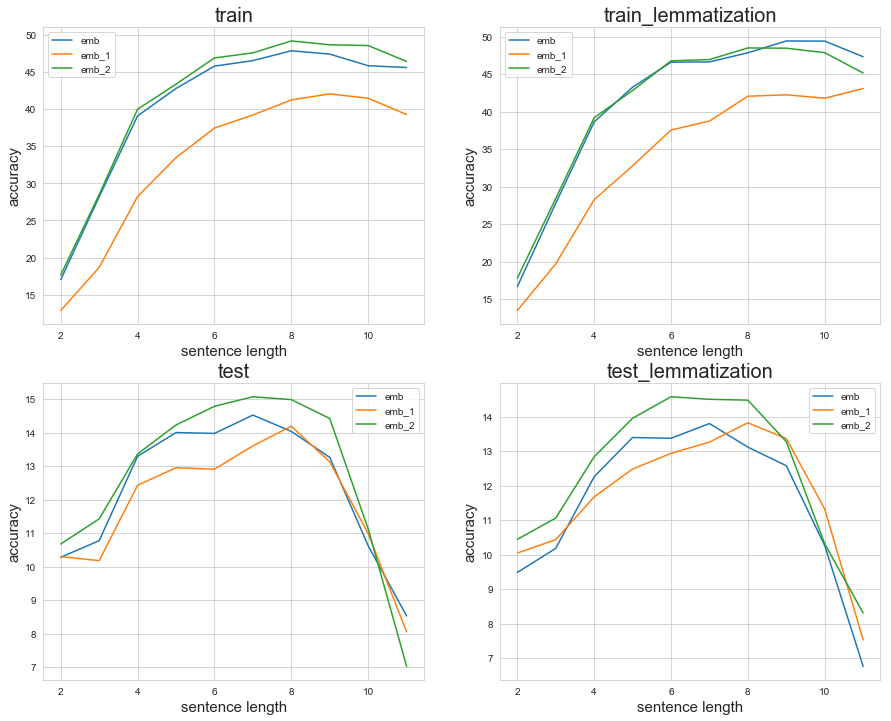

emb_lemmatization.txt 0.22783803134363978 0.26150611826855696
emb_no_lemmatization.txt 0.3014991205041853 0.34950137458897096
emb_1_lemmatization.txt 0.19633970636330692 0.2258530537437335
emb_1_no_lemmatization.txt 0.26651374930391664 0.31058163980378417
emb_2_lemmatization.txt 0.17827689533557847 0.2135302679100857
emb_2_no_lemmatization.txt 0.2518495929569622 0.30184895692954555


In [144]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
sns.set_style("whitegrid")

lm = ''
grid = np.arange(0, 10) + 2
bound = len(grid)
for num in ['', '_1', '_2']:
    path = 'emb' + num + lm + '_lemmatization.txt'
    plt.plot(grid, 100*np.array(train_st[path][:bound], dtype=float) * (1-train_pad[path]), label='emb'+num)
        
plt.legend()
plt.xlabel('sentence length', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('train', fontsize=20)


plt.subplot(2, 2, 2)

lm = '_no'
for num in ['', '_1', '_2']:
    path = 'emb' + num + lm + '_lemmatization.txt'
    plt.plot(grid, 100*np.array(train_st[path][:bound], dtype=float) * (1-train_pad[path]), label='emb'+num)
        
plt.legend()
plt.xlabel('sentence length', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('train_lemmatization', fontsize=20)

plt.subplot(2, 2, 3)

lm = ''
for num in ['', '_1', '_2']:
    path = 'emb' + num + lm + '_lemmatization.txt'
    plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), label='emb'+num)

plt.legend()
plt.xlabel('sentence length', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('test', fontsize=20)

plt.subplot(2, 2, 4)

lm = '_no'
for num in ['', '_1', '_2']:
    path = 'emb' + num + lm + '_lemmatization.txt'
    plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), label='emb'+num)

plt.legend()
plt.xlabel('sentence length', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('test_lemmatization', fontsize=20)
plt.show()



for num in ['', '_1', '_2']:
    for lm in ['', '_no']:
        path = 'emb' + num + lm + '_lemmatization.txt'
        print(path, train_pad[path], test_pad[path])

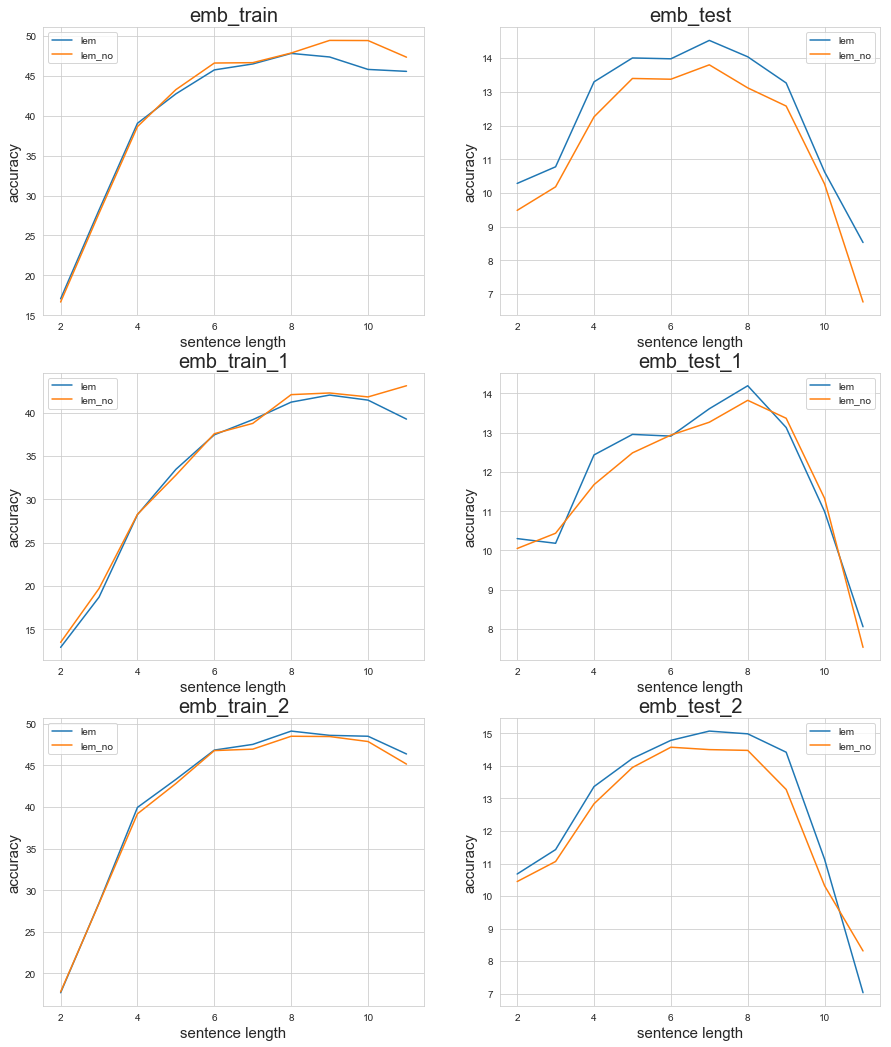

In [153]:
plt.figure(figsize=(15, 18))


for i, num in enumerate(['', '_1', '_2']):
    plt.subplot(3, 2, i*2+1)
    for lm in ['', '_no']:
        path = 'emb' + num + lm + '_lemmatization.txt'
        plt.plot(grid, 100*np.array(train_st[path][:bound], dtype=float) * (1-train_pad[path]), label='lem'+lm)
        
    plt.legend()
    plt.xlabel('sentence length', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
    plt.title('emb_train'+num, fontsize=20)
    
    plt.subplot(3, 2, i*2+2)
    for lm in ['', '_no']:
        path = 'emb' + num + lm + '_lemmatization.txt'
        plt.plot(grid, 100*np.array(test_st[path][:bound], dtype=float) * (1-test_pad[path]), label='lem'+lm)
        
    plt.legend()
    plt.xlabel('sentence length', fontsize=15)
    plt.ylabel('accuracy', fontsize=15)
    plt.title('emb_test'+num, fontsize=20)

plt.show()

# to try

добавить метрику в топ-5/10

попробовать для других эмбеддингов и с лемматизацией

добавить простые фичи слов / использовать лемматизацию но предсказывать исходное

русский / английский в запросе?

attention?

опечатки?

In [ ]:
the_model = TheModelClass(*args, **kwargs)
the_model.load_state_dict(torch.load(PATH))